In [47]:
import pandas as pd
import re
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [48]:
df = pd.read_csv(r"F:\Car-Price_pridction-app\Car-Price-Prediction-Model\rawdata.csv", encoding="latin1")


In [49]:
df.head()

,Car Name,KM Driven,Fuel Type,Transmission,Ownership,Price,Location
0,2018 Datsun Go REMIX EDITION,99.58k km,Petrol,Manual,2nd owner,2.72L,"KW Delhi 6, Raj Nagar Extension, Ghaziabad"
1,2018 Maruti Swift LXI,81.41k km,Petrol,Manual,1st owner,4.58L,"M3M Urbana, Golf Course Ext., Gurugram"
2,2024 Nissan MAGNITE XE,13.33k km,Petrol,Manual,1st owner,5.30 lakh,"Metro Walk, Rohini, New Delhi"
3,2021 Hyundai Verna S PLUS 1.5 VTVT,33.75k km,Petrol,Manual,1st owner,8.30L,"Vaishali, Ghaziabad"
4,2021 Hyundai NEW I20,241 km,Diesel,Manual,1st owner,6.78L,"M3M Urbana, Golf Course Ext., Gurugram"


# Data_Cleaning 


In [50]:
def clean_car_name(car_str):
    """Extract model year, brand, model, and variant from car name string."""
    parts = car_str.split()
    
    # Find year
    year = next((p for p in parts if re.match(r'^\d{4}$', p)), None)
    
    if year:
        year_idx = parts.index(year)
        brand = parts[year_idx + 1] if year_idx + 1 < len(parts) else None
        model = parts[year_idx + 2] if year_idx + 2 < len(parts) else None
        variant = ' '.join(parts[year_idx + 3:]) if year_idx + 3 < len(parts) else None
    else:
        brand = model = variant = None

    return {
        'model_year': int(year) if year else None,
        'brand_name': brand,
        'model_name': model,
        'variant': variant
    }

In [51]:
def clean_Km_driven(km_str):
    """
    Converts strings like '99.58k km' or '241 km' into numeric km float values.
    """
    if not isinstance(km_str, str):
        return None  # Handle non-string input gracefully

    # Remove commas and whitespace
    km_str = km_str.replace(',', '').strip().lower()

    # Extract numeric value and multiplier
    match = re.match(r'([\d\.]+)(k)?\s*km', km_str)
    if match:
        value = float(match.group(1))
        multiplier = 1000 if match.group(2) == 'k' else 1
        return value * multiplier

    return 0.0  # Return 0.0 if pattern doesn't match

In [52]:
def clean_ownership(owner_str):
    """
    Extracts numeric ownership level from strings like '1st owner', '2nd owner', etc.
    """
    if not isinstance(owner_str, str):
        return None

    # Regex to extract leading number
    match = re.match(r'^(\d+)', owner_str.lower())
    return int(match.group(1)) if match else None

In [53]:

def clean_price(price_str):
    """
    Converts price strings like '2.72L' or '5.30 lakh' to numeric INR values.
    Assumes 1 Lakh = 100000.
    """
    if not isinstance(price_str, str):
        return None

    price_str = price_str.lower().replace(',', '').strip()
    
    # Match decimal number + possible unit
    match = re.match(r'([\d\.]+)\s*(l|lakh)', price_str)
    
    if match:
        amount = float(match.group(1))
        return int(amount * 100000)

    return None  # Handle edge cases

In [54]:
def clean_location(loc_str):
    """
    Extracts the city name (last segment) from a location string.
    E.g. 'Metro Walk, Rohini, New Delhi' → 'New Delhi'
    """
    if not isinstance(loc_str, str):
        return None

    parts = [p.strip() for p in loc_str.split(',')]
    return parts[-1] if parts else None

## ALL_Data Cleaning 

In [55]:
# Step 1: Parse 'Car Name' into structured fields
df_car_parsed = df['Car Name'].apply(clean_car_name).apply(pd.Series)

# Step 2: Combine with original DataFrame into a new one
clean_df = pd.concat([df.copy(), df_car_parsed], axis=1)
clean_df['KM Driven'] = clean_df['KM Driven'].apply(clean_Km_driven)
clean_df['Ownership'] = clean_df['Ownership'].apply(clean_ownership)
clean_df['Price'] = clean_df['Price'].apply(clean_price)
clean_df['City'] = clean_df['Location'].apply(clean_location)
clean_df = clean_df.drop(columns=['Car Name','Location','variant'], errors='ignore')
clean_df.columns = [col.strip().lower().replace(' ', '_') for col in clean_df.columns]
clean_df = clean_df[clean_df['model_year'] != 2025]
object_cols = clean_df.select_dtypes(include='object').columns

# Apply lowercase transformation with safe handling
clean_df[object_cols] = clean_df[object_cols].apply(lambda col: col.str.lower().str.strip())
clean_df.drop_duplicates(inplace=True)



In [56]:
clean_df.head()

,km_driven,fuel_type,transmission,ownership,price,model_year,brand_name,model_name,city
0,99580.0,petrol,manual,2,272000,2018,datsun,go,ghaziabad
1,81410.0,petrol,manual,1,458000,2018,maruti,swift,gurugram
2,13330.0,petrol,manual,1,530000,2024,nissan,magnite,new delhi
3,33750.0,petrol,manual,1,830000,2021,hyundai,verna,ghaziabad
4,241.0,diesel,manual,1,678000,2021,hyundai,new,gurugram


In [57]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3129 entries, 0 to 3273
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   km_driven     3129 non-null   float64
 1   fuel_type     3129 non-null   object 
 2   transmission  3129 non-null   object 
 3   ownership     3129 non-null   int64  
 4   price         3129 non-null   int64  
 5   model_year    3129 non-null   int64  
 6   brand_name    3129 non-null   object 
 7   model_name    3129 non-null   object 
 8   city          3128 non-null   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 244.5+ KB


In [58]:
print(clean_df.duplicated().sum())

0


### EDA

In [59]:
clean_df.describe()

,km_driven,ownership,price,model_year
count,3129.000000,3129.000000,3.129000e+03,3129.000000
mean,44872.221157,1.396932,6.162703e+05,2018.007990
std,29374.118549,0.722981,4.470518e+05,3.628831
min,0.000000,1.000000,4.500000e+04,2005.000000
25%,21730.000000,1.000000,3.500000e+05,2015.000000
50%,45260.000000,1.000000,5.320000e+05,2018.000000
75%,69010.000000,2.000000,7.500000e+05,2021.000000
max,100000.000000,7.000000,4.800000e+06,2024.000000


In [60]:
clean_df.isnull().sum()

km_driven       0
fuel_type       0
transmission    0
ownership       0
price           0
model_year      0
brand_name      0
model_name      0
city            1
dtype: int64

In [61]:
clean_df['city'] = clean_df['city'].fillna(clean_df['city'].mode()[0])


In [62]:
clean_df.isnull().sum()

km_driven       0
fuel_type       0
transmission    0
ownership       0
price           0
model_year      0
brand_name      0
model_name      0
city            0
dtype: int64

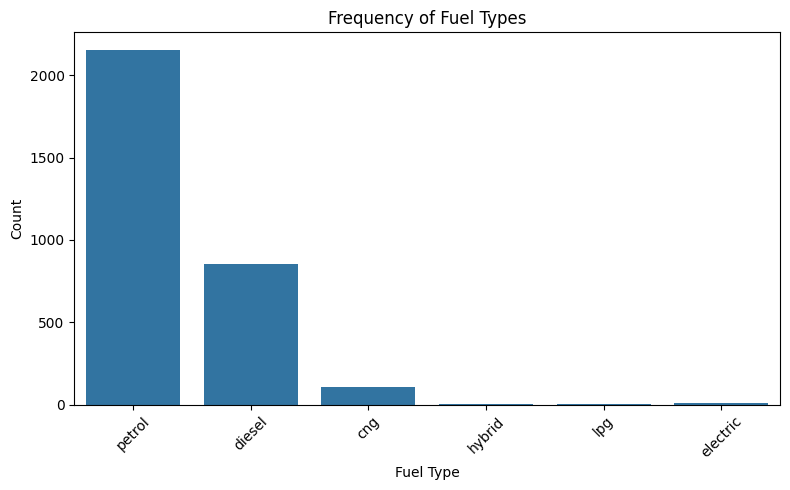

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.countplot(data=clean_df, x='fuel_type')
plt.title('Frequency of Fuel Types')
plt.xlabel('Fuel Type')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Optional: tilt x-labels
plt.tight_layout()
plt.show()

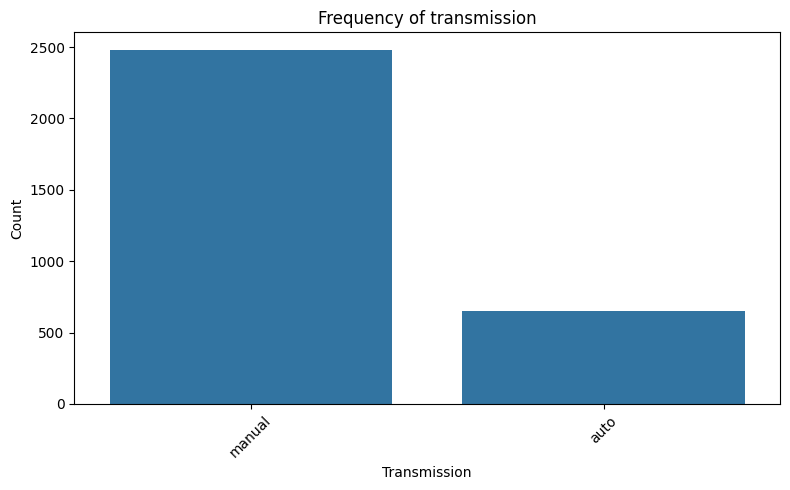

In [64]:
plt.figure(figsize=(8, 5))
sns.countplot(data=clean_df, x='transmission')
plt.title('Frequency of transmission')
plt.xlabel('Transmission')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Optional: tilt x-labels
plt.tight_layout()
plt.show()

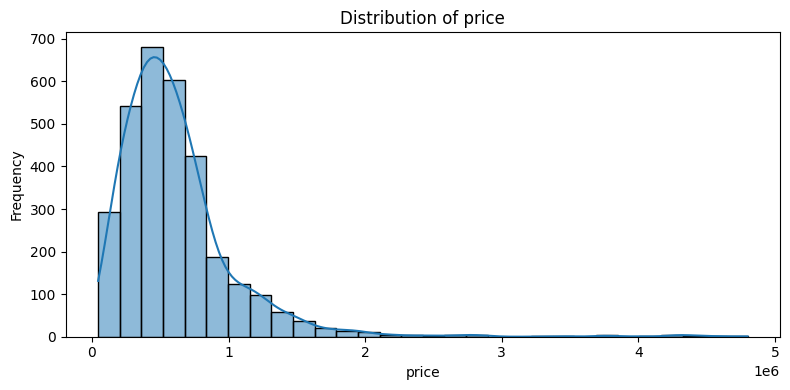

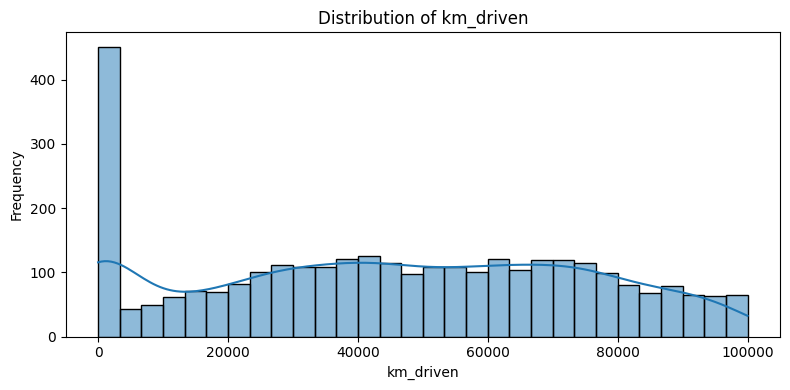

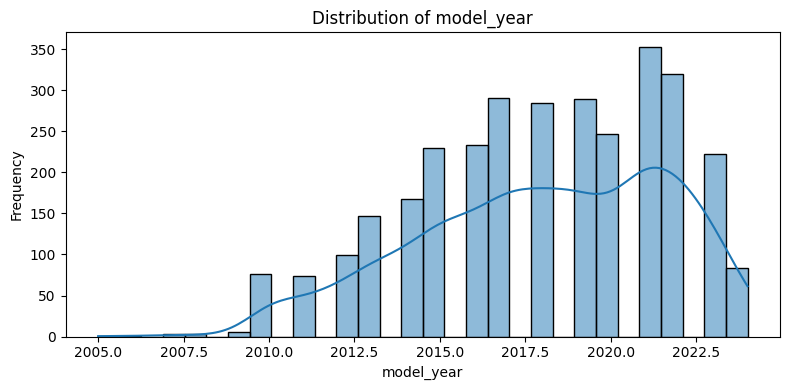

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select numeric columns to visualize
numeric_cols = ['price', 'km_driven', 'model_year']

for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(data=clean_df, x=col, kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

### Feature Engineering

In [66]:
from datetime import datetime

# Get current year automatically
current_year = datetime.now().year

# Calculate car_age
clean_df['car_age'] = current_year - clean_df['model_year']

In [67]:
import numpy as np
price_cap = np.percentile(clean_df['price'], 99.5)
travel_cap = np.percentile(clean_df['km_driven'], 99.5)
clean_df = clean_df[(clean_df['price'] <= price_cap) & (clean_df['km_driven'] <= travel_cap)]

In [68]:
clean_df.head()

,km_driven,fuel_type,transmission,ownership,price,model_year,brand_name,model_name,city,car_age
1,81410.0,petrol,manual,1,458000,2018,maruti,swift,gurugram,7
2,13330.0,petrol,manual,1,530000,2024,nissan,magnite,new delhi,1
3,33750.0,petrol,manual,1,830000,2021,hyundai,verna,ghaziabad,4
4,241.0,diesel,manual,1,678000,2021,hyundai,new,gurugram,4
5,8920.0,petrol,manual,1,565000,2024,tata,punch,gurugram,1


### Encoding categorical variables

In [69]:
# one Hot Encoding categorical variables eg., Fuel Type, Transmission, etc.

encoded_df = pd.get_dummies(clean_df[['fuel_type', 'transmission']], 
                            prefix=['fuel', 'trans'], 
                            dtype=int)

# Drop original columns and merge encoded ones
clean_df = pd.concat([clean_df.drop(['fuel_type', 'transmission'], axis=1), encoded_df], axis=1)



In [70]:
target_column = 'price'

# Target encoding for each feature
for col in ['brand_name', 'model_name']:
    encoding_map = clean_df.groupby(col)[target_column].mean()
    clean_df[f'{col}_target_enc'] = clean_df[col].map(encoding_map)


In [71]:
clean_df.head()

,km_driven,ownership,price,model_year,brand_name,model_name,city,car_age,fuel_cng,fuel_diesel,fuel_electric,fuel_hybrid,fuel_lpg,fuel_petrol,trans_auto,trans_manual,brand_name_target_enc,model_name_target_enc
1,81410.0,1,458000,2018,maruti,swift,gurugram,7,0,0,0,0,0,1,0,1,454008.940315,406571.365714
2,13330.0,1,530000,2024,nissan,magnite,new delhi,1,0,0,0,0,0,1,0,1,559561.350877,646256.358974
3,33750.0,1,830000,2021,hyundai,verna,ghaziabad,4,0,0,0,0,0,1,0,1,552003.138756,664338.147059
4,241.0,1,678000,2021,hyundai,new,gurugram,4,0,1,0,0,0,0,0,1,552003.138756,541942.790476
5,8920.0,1,565000,2024,tata,punch,gurugram,1,0,0,0,0,0,1,0,1,679624.195266,708689.586207


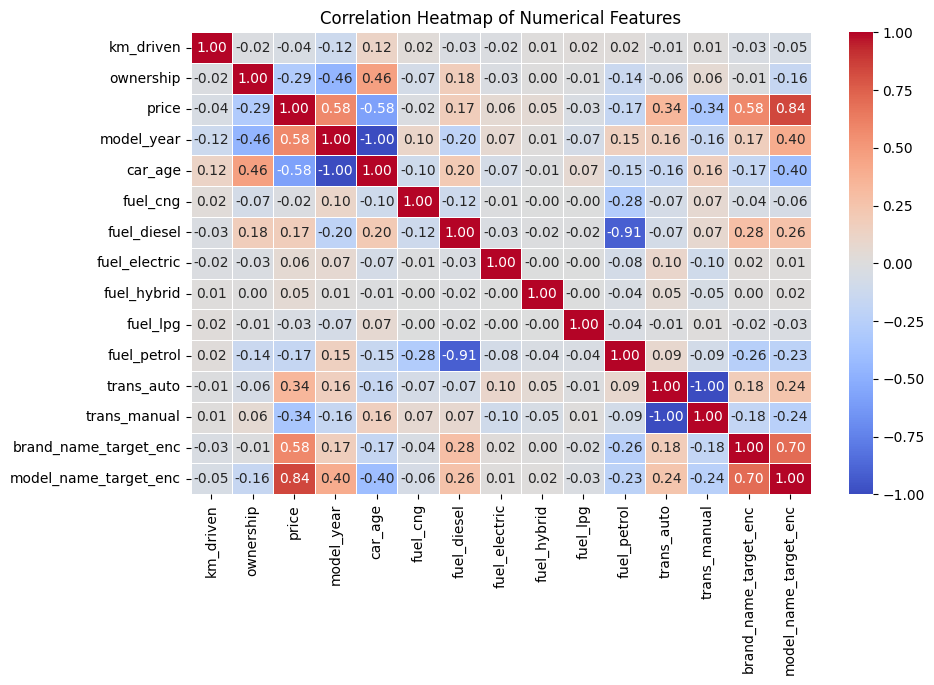

In [72]:
corr_matrix = clean_df.corr(numeric_only=True)

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

### Model building

In [73]:
target = 'price'
features = clean_df.drop(columns=[target]).select_dtypes(include=['number']).columns

X = clean_df[features]
y = clean_df[target]

### Splite data 

In [74]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [75]:

model = CatBoostRegressor(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    verbose=100
)

model.fit(X_train, y_train)


0:	learn: 343623.2425721	total: 1.32ms	remaining: 660ms
100:	learn: 117860.1127426	total: 107ms	remaining: 424ms
200:	learn: 95209.2023184	total: 216ms	remaining: 321ms
300:	learn: 85779.5829845	total: 325ms	remaining: 215ms
400:	learn: 78835.4655557	total: 435ms	remaining: 108ms
499:	learn: 73481.8224950	total: 544ms	remaining: 0us


In [76]:
y_pred = model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred) ** 0.5
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")
print(f"MAE: {mae:.2f}")


RMSE: 135985.70
R² Score: 0.88
MAE: 80198.13


Text(0.5, 1.0, 'Train Set: Actual vs Predicted')

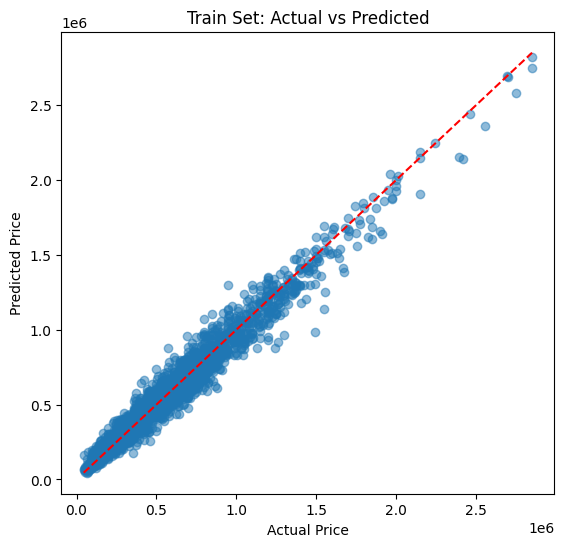

In [77]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Plot setup
plt.figure(figsize=(14, 6))

# Train set
plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred, alpha=0.5)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')  # Identity line
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Train Set: Actual vs Predicted')